In [1]:
#!pip install celery
#!pip install jsonpickle

In [2]:
#!sudo rabbitmqctl add_user myguest myguestpwd
#!sudo rabbitmqctl set_permissions -p / myguest "." "." ".*"

In [3]:
#!sudo rabbitmqctl list_users

In [4]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from copy import deepcopy

from celery import group
from kmeans_workers import kmeans_tasks, dist


In [5]:
#import jsonpickle
#import jsonpickle.ext.numpy as jsonpickle_numpy
#jsonpickle_numpy.register_handlers()


In [6]:
n_samples=1600
n_clusters=3
n_features =2
n_workers = 4

In [7]:
#class PointsLabels():
#    def __init__(self,X,y):
#        #print(X)
#        self.points = np.array(X)
#        self.label = y
#        #print('X:',X)
#        #print('label:',y)
#    def toJSON(self):
#        return json.dumps(self, default=lambda o: o.__dict__, 
#            sort_keys=True, indent=4)
#        
#mydata= [PointsLabels(x,np.random.randint(n_clusters)) for x in Xs]


In [8]:
# Creating a n_features=2 Dim dataset with centers=3 clusters
Xs, Ys = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters)

In [9]:
mydata= [{"points": x, "label": np.random.randint(n_clusters)} for x in Xs]

In [10]:
print(len(mydata))
print(mydata[15]['points'],mydata[15]['label'])

1600
[-10.05985861  -8.04971492] 0


In [11]:
# Split the sequence in a number of chunks and process those independently.

l = n_samples // n_workers
Xsubseqs = [mydata[i * l:(i + 1) * l] for i in range(n_workers - 1)]
Xsubseqs.append(mydata[(n_workers - 1) * l:])


In [12]:
len(Xsubseqs[0])

400

In [13]:
np.matrix(np.diag(np.max(Xs,0)))

matrix([[10.95442811,  0.        ],
        [ 0.        ,  2.18201761]])

In [14]:
C=np.matrix(np.random.rand(n_clusters,n_features))*np.matrix(np.diag(np.max(Xs,0)))
print("Initial Centroids")
print(C)


Initial Centroids
[[2.16744062 1.36579106]
 [9.18651525 1.94548327]
 [8.85970541 0.49357497]]


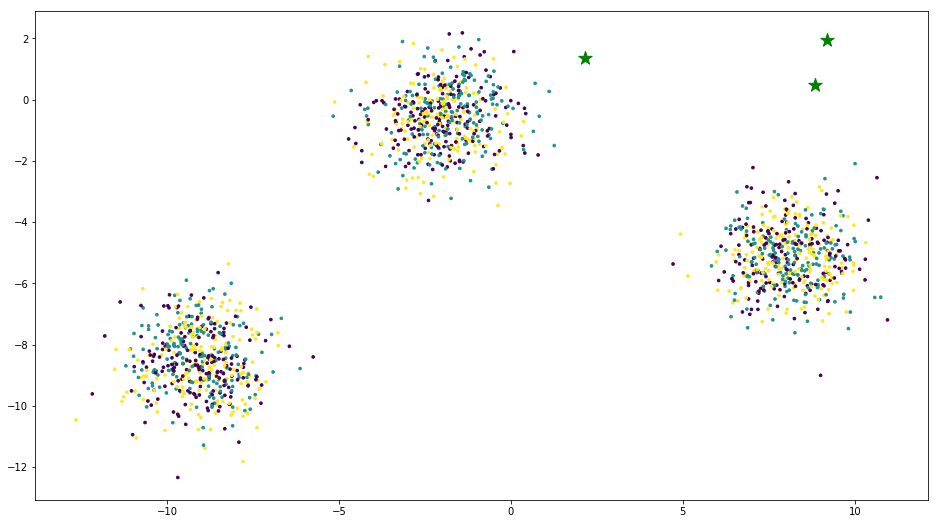

In [15]:
plt.rcParams['figure.figsize'] = (16, 9)
fig = plt.figure()

# Plotting along with the Centroids
#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata])
plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata],c=[actdata['label'] for actdata in mydata], s=7)

plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')


In [16]:
len([actdata['label'] for actdata in mydata])

1600

In [17]:
# To store the value of centroids when it updates
C_old = np.zeros(C.shape)
# Error func. - Distance between new centroids and old centroids
error = dist(C, C_old, None)
print(error)

13.171110349935159


In [18]:
print(C)
print(C.shape)

[[2.16744062 1.36579106]
 [9.18651525 1.94548327]
 [8.85970541 0.49357497]]
(3, 2)


In [19]:
import json

In [20]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.int64): 
            return int(obj)
        return json.JSONEncoder.default(self, obj)



In [21]:
partials_Estep=[kmeans_tasks(task='estep', json_dump = json.dumps({'C': C, 'X': seq}, cls=NumpyEncoder)) for seq in Xsubseqs]

*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***


In [22]:
# the updated labels are here:
len(partials_Estep[0])

400

In [23]:
len(partials_Estep)

4

In [24]:
partials_Mstep=[kmeans_tasks(task='mstep', json_dump = json.dumps({'X': seq, 'n_clusters': n_clusters, 'n_features':n_features}, cls=NumpyEncoder)) for seq in partials_Estep]

*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:
[0]*int(5)

[0, 0, 0, 0, 0]

In [26]:
partials_Mstep

[[array([-5.74229283, -4.846654  ]),
  array([0., 0.]),
  array([ 8.05084955, -5.20252325])],
 [array([-5.43635379, -4.49459633]),
  array([0., 0.]),
  array([ 8.01077195, -5.27265763])],
 [array([-5.64129883, -4.67644328]),
  array([0., 0.]),
  array([ 8.16671638, -4.99080407])],
 [array([-5.21420355, -4.2046302 ]),
  array([0., 0.]),
  array([ 8.14942151, -5.06739088])]]

In [27]:
C=np.sum(partials_Mstep,0)/n_workers
print(C)

[[-5.50853725 -4.55558095]
 [ 0.          0.        ]
 [ 8.09443985 -5.13334396]]


In [28]:
# Storing the old centroid values
C_old = deepcopy(C)
 

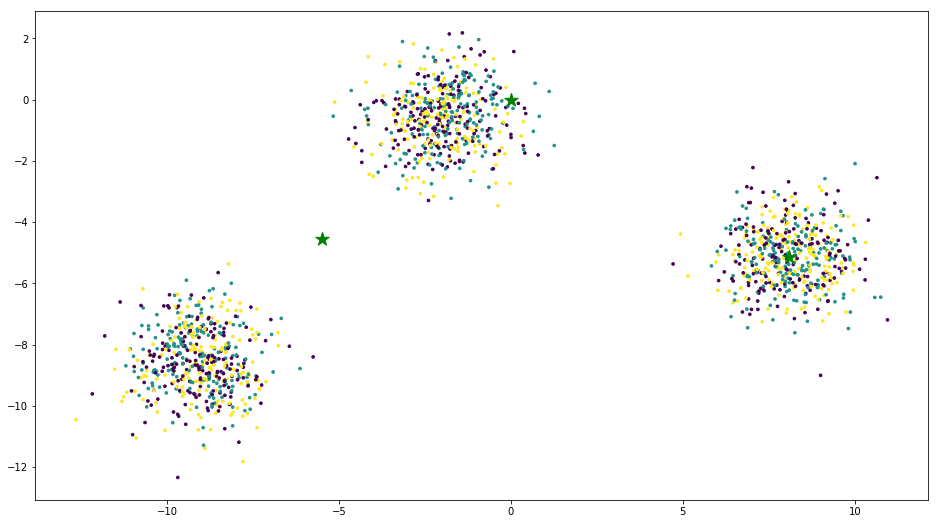

In [29]:
# Plotting along with the Centroids

#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c='#050505', s=7)
plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata],c=[actdata['label'] for actdata in mydata], s=7)
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')


### Everything together

(3, 2)
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
0.0
400
400
400
400


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


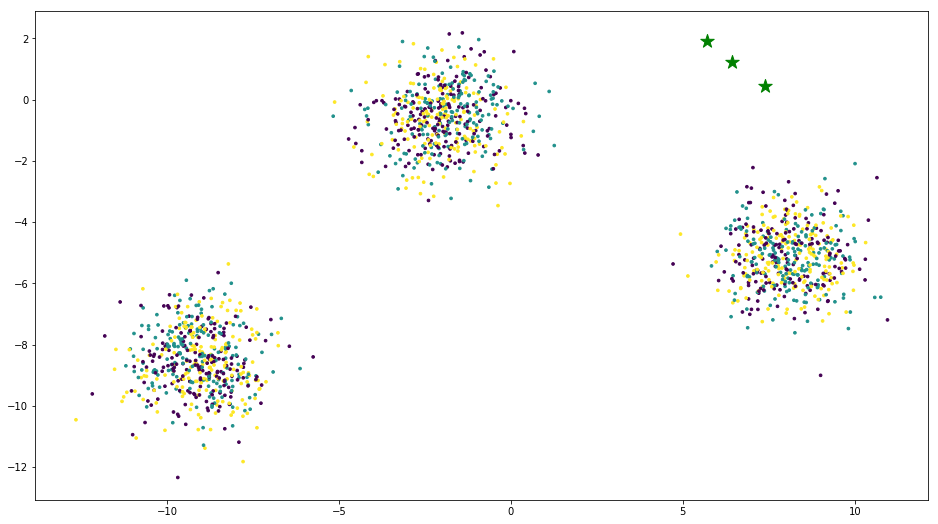

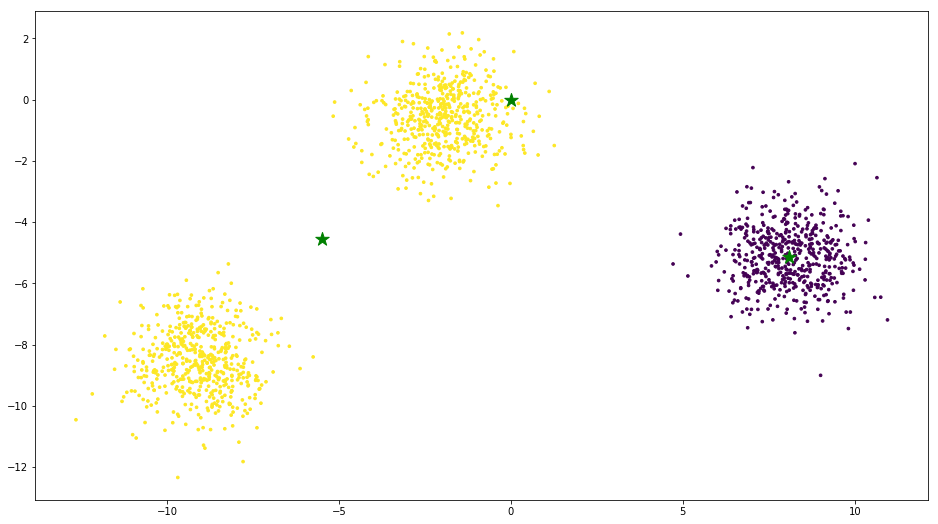

(3, 2)
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
0.0
400
400
400
400


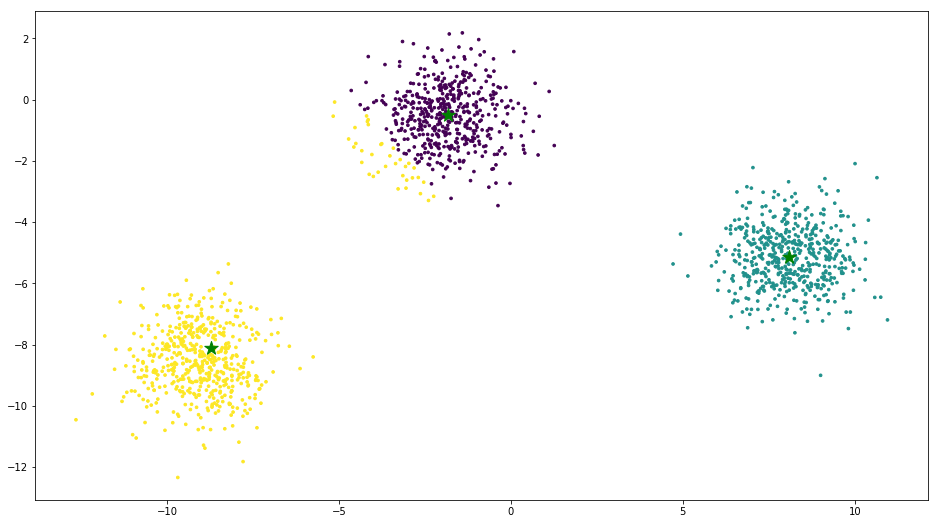

(3, 2)
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
0.0
400
400
400
400


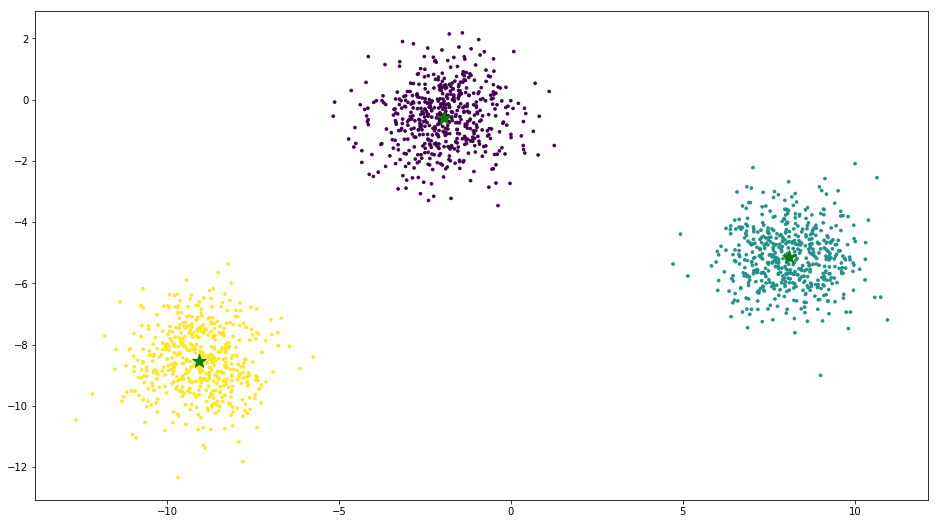

(3, 2)
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
0.0
400
400
400
400


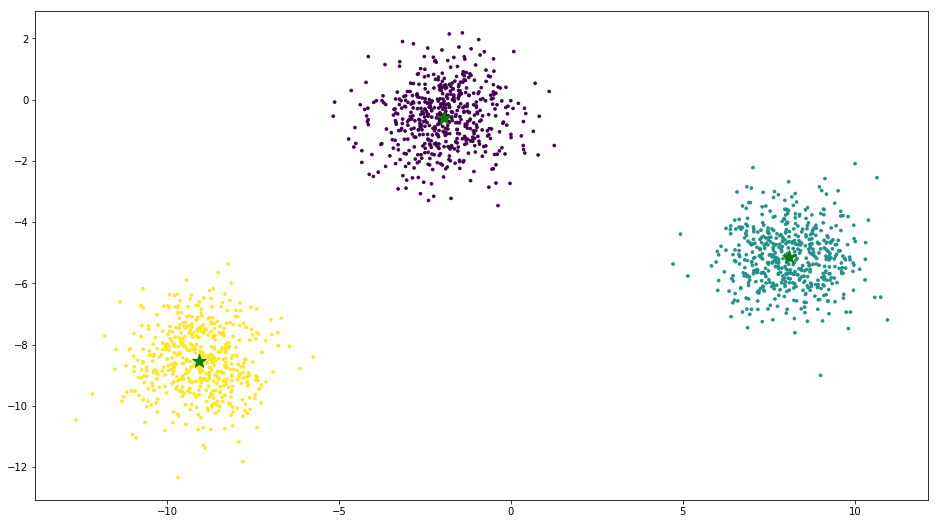

(3, 2)
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
0.0
400
400
400
400


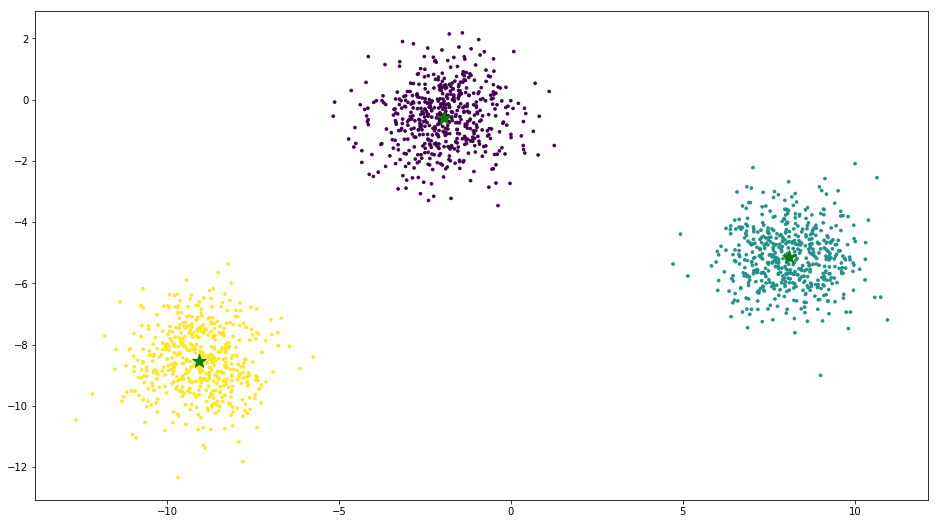

In [30]:
# Split the sequence in a number of chunks and process those independently.
n_workers = 4
n_iter =5

l = n_samples // n_workers
Xsubseqs = [mydata[i * l:(i + 1) * l] for i in range(n_workers - 1)]
Xsubseqs.append(mydata[(n_workers - 1) * l:])
C=np.matrix(np.random.rand(n_clusters,n_features))*np.matrix(np.diag(np.max(Xs,0)))

#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c='#050505', s=7)
plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata],c=[actdata['label'] for actdata in mydata], s=7)
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')

for iter in range(0, n_iter):    

    print(C.shape)
    
    #class assignnment
    partials_Estep=[kmeans_tasks(task='estep', json_dump = json.dumps({'C': C, 'X': seq}, cls=NumpyEncoder)) for seq in Xsubseqs]
    
    #centroid update assignnment
    partials_Mstep=[kmeans_tasks(task='mstep', json_dump = json.dumps({'X': seq, 'n_clusters': n_clusters, 'n_features':n_features}, cls=NumpyEncoder)) for seq in partials_Estep]
    
    C=np.sum(partials_Mstep,0)/n_workers
    C_old = deepcopy(C)
    error = dist(C, C_old, None)
    print(error)

    Xsubseqs=deepcopy(partials_Estep)
    
    mydata_updated=[]
    for seq in partials_Estep:
        mydata_updated.extend(seq)
        print(len(seq))
    len(mydata_updated)

    plt.rcParams['figure.figsize'] = (16, 9)
    fig = plt.figure()
    plt.scatter([actdata['points'][0] for actdata in mydata_updated], [actdata['points'][1] for actdata in mydata_updated],c=[actdata['label'] for actdata in mydata_updated], s=7)

    plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')
    plt.show()
    
    #time.sleep(2)


### Distributed Kmeans

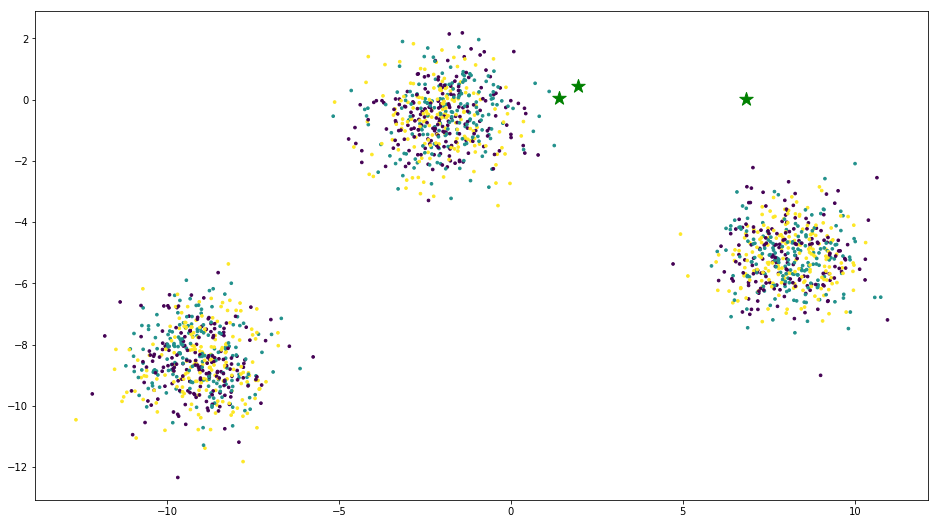

In [32]:
# Split the sequence in a number of chunks and process those independently.
n_workers = 4
n_iter =5

l = n_samples // n_workers
Xsubseqs = [mydata[i * l:(i + 1) * l] for i in range(n_workers - 1)]
Xsubseqs.append(mydata[(n_workers - 1) * l:])
C=np.matrix(np.random.rand(n_clusters,n_features))*np.matrix(np.diag(np.max(Xs,0)))

#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c='#050505', s=7)
plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata],c=[actdata['label'] for actdata in mydata], s=7)
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')


In [28]:
for iter in range(0, n_iter):    

    print(C.shape)
    
    #class assignnment
    lazy_partials_Estep = group(kmeans_tasks.s(task='estep', json_dump = 
                                               json.dumps({'C': C, 'X': seq}, cls=NumpyEncoder) for seq in Xsubseqs)() 
    # call remote workers to run the sort task 
    partials_Estep = lazy_partials_Estep.get() # will wait for the tasks to return

    #partials_Estep=[kmeans_tasks(task='estep', json_dump = json.dumps({'C': C, 'X': seq}, cls=NumpyEncoder)) for seq in Xsubseqs]
    
    #centroid update assignnment
    lazy_partials_Mstep = group(kmeans_tasks.s(task='mstep', json_dump = 
                                               json.dumps({'X': seq, 'n_clusters': n_clusters, 'n_features':n_features}, 
                                                          cls=NumpyEncoder)) for seq in partials_Estep)()
    partials_Mstep = lazy_partials_Mstep.get()               
    #partials_Mstep=[kmeans_tasks(task='mstep', json_dump = json.dumps({'X': seq, 'n_clusters': n_clusters, 'n_features':n_features}, cls=NumpyEncoder)) for seq in partials_Estep]
    
    C=np.sum(partials_Mstep,0)/n_workers
    C_old = deepcopy(C)
    error = dist(C, C_old, None)
    print(error)

    Xsubseqs=deepcopy(partials_Estep)
    
    mydata_updated=[]
    for seq in partials_Estep:
        mydata_updated.extend(seq)
        print(len(seq))
    len(mydata_updated)

    plt.rcParams['figure.figsize'] = (16, 9)
    fig = plt.figure()
    plt.scatter([actdata['points'][0] for actdata in mydata_updated], [actdata['points'][1] for actdata in mydata_updated],c=[actdata['label'] for actdata in mydata_updated], s=7)

    plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')
    plt.show()
    
    #time.sleep(2)

    
    



(3, 2)


AttributeError: 'dict' object has no attribute 'points'

In [30]:
import json

In [32]:
json_dump = json.dumps({'C': C, 'bb': [2]}, cls=NumpyEncoder)
print(json_dump)

{"C": [[13.020463947581199, 0.07052950786714818], [9.631652509152199, 1.0954549631465391], [3.2663937221918804, 4.153578766189129]], "bb": [2]}


In [33]:
json_load = json.loads(json_dump)

C_restored = np.asarray(json_load["C"])
print(C_restored)
print(C_restored.shape)


[[13.02046395  0.07052951]
 [ 9.63165251  1.09545496]
 [ 3.26639372  4.15357877]]
(3, 2)


In [45]:
json_dump

'{"C": [[13.020463947581199, 0.07052950786714818], [9.631652509152199, 1.0954549631465391], [3.2663937221918804, 4.153578766189129]], "bb": [2], "mydata": [{"points": [0.31023440974208893, 8.320471713542032], "label": 2}, {"points": [6.164363661370043, 1.0266887279818464], "label": 0}, {"points": [5.366193149142304, -0.7548547518009948], "label": 1}, {"points": [-0.12344255569391126, 10.109444795755095], "label": 0}, {"points": [0.18240232283824787, 7.760121738286829], "label": 1}, {"points": [-0.732448596866407, -7.3938310144361115], "label": 0}, {"points": [-0.0009431868541326383, 8.709708429388748], "label": 2}, {"points": [6.097525916045434, -1.5301561711907543], "label": 2}, {"points": [-1.6453975132696976, -8.485998497683422], "label": 1}, {"points": [2.1621610463952217, 9.299325784150117], "label": 1}, {"points": [1.6541483904500642, 7.4993400449756145], "label": 0}, {"points": [-1.263935233510719, -7.337546497674661], "label": 0}, {"points": [-1.60178923033971, -7.2426602600762

In [43]:
decoded[0].label

1